In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#display configurations
%config InlineBackend.figure_format = 'retina'
from sklearn import set_config
set_config(display='diagram', transform_output='pandas')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [3]:
ml_df=pd.read_csv("/bsuhome/maishamaliha/scratch/First_chapter_ML/ml_dataset_14site.csv")
#ml_df.info() 

In [21]:
#ml_df['Species'].value_counts()

In [22]:
#ml_df.isnull().sum()

In [4]:
#removing null values
ml_df= ml_df.dropna()
ml_df.isnull().sum()
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10112 entries, 0 to 10129
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Species                  10112 non-null  object 
 1   site                     10112 non-null  object 
 2   area                     10112 non-null  float64
 3   perimeter                10112 non-null  float64
 4   edge_to_area_ratio       10112 non-null  float64
 5   rgb_stdev.red            10112 non-null  float64
 6   rgb_stdev.green          10112 non-null  float64
 7   rgb_stdev.blue           10112 non-null  float64
 8   rgb_mean.red             10112 non-null  float64
 9   rgb_mean.green           10112 non-null  float64
 10  rgb_mean.blue            10112 non-null  float64
 11  multispec_stdev.Red      10112 non-null  float64
 12  multispec_stdev.RedEdge  10112 non-null  float64
 13  multispec_stdev.NIR      10112 non-null  float64
 14  multispec_mean.Red       10

In [5]:
plt.figure(figsize=(11, 6))

val_count=ml_df['Species'].value_counts()
val_count

Species
ARTR       5438
ARAR       2503
CHVI        453
ERNA        350
ARTRW       287
Dead        233
AGCR        215
PUTR        173
ACTH        128
ELEL         94
Lupinus      93
PSSP         82
Cirsium      22
ARTRV        21
CHJU         20
Name: count, dtype: int64

<Figure size 1100x600 with 0 Axes>

In [5]:
ml_df['Species'] = ml_df['Species'].replace({'ARTRW': 'ARTR', 'ARTRV': 'ARTR'})
ml_df['Species'].unique()

array(['ACTH', 'AGCR', 'ARAR', 'ARTR', 'CHJU', 'CHVI', 'Cirsium', 'Dead',
       'ELEL', 'ERNA', 'Lupinus', 'PSSP', 'PUTR'], dtype=object)

In [6]:
val_count=ml_df['Species'].value_counts()
val_count

Species
ARTR       5746
ARAR       2503
CHVI        453
ERNA        350
Dead        233
AGCR        215
PUTR        173
ACTH        128
ELEL         94
Lupinus      93
PSSP         82
Cirsium      22
CHJU         20
Name: count, dtype: int64

<Axes: xlabel='site'>

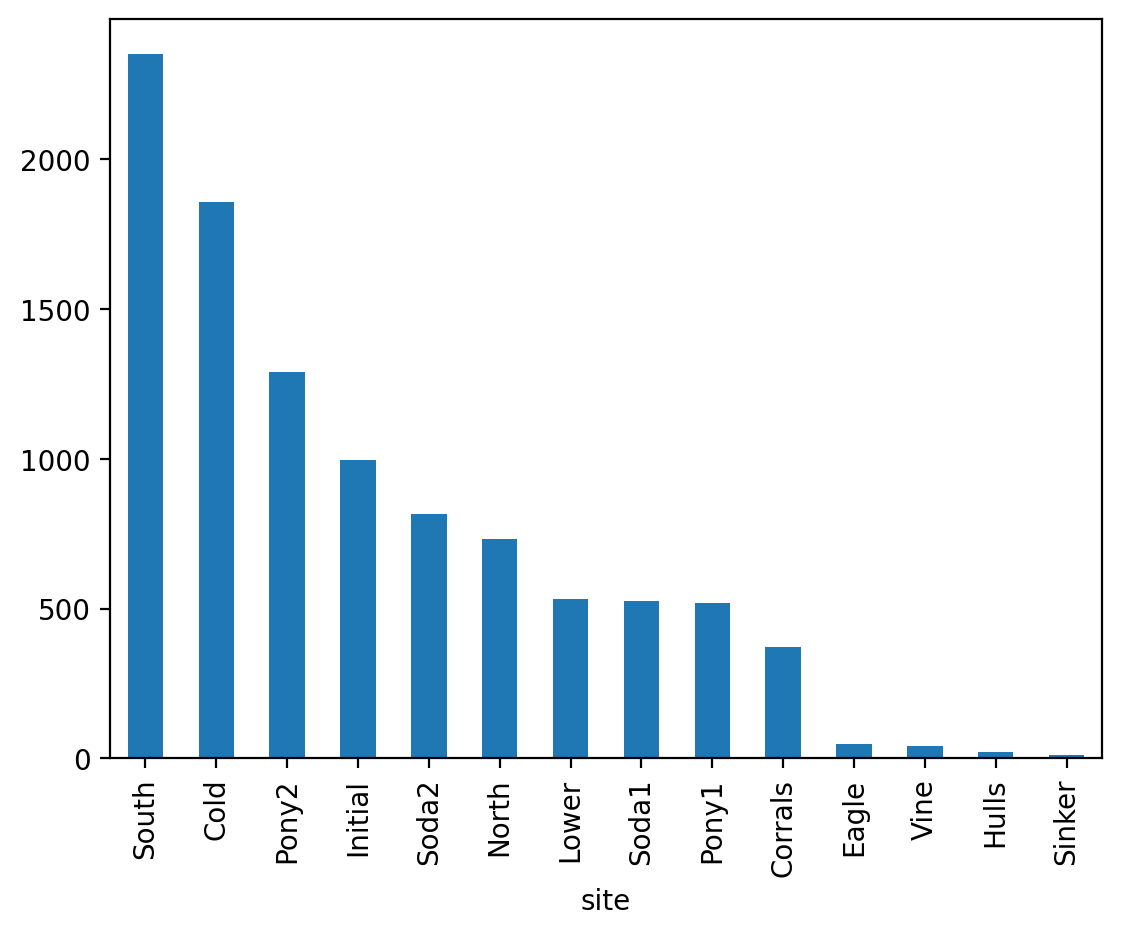

In [8]:
val_count=ml_df['site'].value_counts()
val_count.plot.bar()

In [9]:
ml_df['site'].describe()

count     10112
unique       14
top       South
freq       2350
Name: site, dtype: object

In [31]:
ml_df.columns.tolist()

['Species',
 'site',
 'area',
 'perimeter',
 'edge_to_area_ratio',
 'rgb_stdev.red',
 'rgb_stdev.green',
 'rgb_stdev.blue',
 'rgb_mean.red',
 'rgb_mean.green',
 'rgb_mean.blue',
 'multispec_stdev.Red',
 'multispec_stdev.RedEdge',
 'multispec_stdev.NIR',
 'multispec_mean.Red',
 'multispec_mean.RedEdge',
 'multispec_mean.NIR',
 'spec_mean.ndvi',
 'spec_mean.msavi',
 'spec_stdev.msavi',
 'spec_stdev.ndvi',
 'chm_mean',
 'chm_stdev',
 'chm_min',
 'chm_max',
 'elev',
 'slope']

In [14]:
features=[
 'area',
 'perimeter',
 'edge_to_area_ratio',
 'rgb_stdev.red',
 'rgb_stdev.green',
 'rgb_stdev.blue',
 'rgb_mean.red',
 'rgb_mean.green',
 'rgb_mean.blue',
 'multispec_stdev.Red',
 'multispec_stdev.RedEdge',
 'multispec_stdev.NIR',
 'multispec_mean.Red',
 'multispec_mean.RedEdge',
 'multispec_mean.NIR',
 'spec_mean.ndvi',
 'spec_mean.msavi',
 'spec_stdev.msavi',
 'spec_stdev.ndvi',
 'chm_mean',
 'chm_stdev',
 'chm_min',
 'chm_max',
 'elev',
 'slope']


numeric_transformer= Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer= Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore",
                             sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features)
        #("cat", categorical_transformer, ['site']),
    ], 
    remainder='drop'
)

In [15]:

import joblib


# pre-trained Stacked Ensemble Model
stacked_model_path = "/bsuhome/maishamaliha/scratch/First_chapter_ML/results/stacked_ensemble_model.joblib"
stacked_model = joblib.load(stacked_model_path)
print(f" Stacked model loaded from: {stacked_model_path}")

def leave_one_out(df):
    """
    Performs Leave-One-Out Cross-Validation (LOO) for each site using 
    Random Forest, Gradient Boosting, and the pre-trained Stacked Ensemble Model.
    Ensures 'site' is NOT used as a feature in training or testing.
    """
    results = {
        'Test_site': [],
        'Model': [],
        'Accuracy': [],
        'F1_Score': []
    }

    for site in df['site'].unique():
        # Split dataset: Leave one site out for testing
        left_out = df[df['site'] == site]  # Test set
        others = df[df['site'] != site]  # Training set

        # Exclude "Species" (target) and "site" (feature to exclude) from training and test sets
        X_train, y_train = others.drop(columns=['Species', 'site']), others['Species']
        X_test, y_test = left_out.drop(columns=['Species', 'site']), left_out['Species']

        # Define Models
        rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
        ])

        gbc_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ])

        # Train models
        rf_model.fit(X_train, y_train)
        gbc_model.fit(X_train, y_train)
        stacked_model.fit(X_train, y_train)  # Ensure Stacking Model is re-trained

        # Predictions
        pred_rf = rf_model.predict(X_test)
        pred_gbc = gbc_model.predict(X_test)
        pred_stacked = stacked_model.predict(X_test)

        # Accuracy Scores
        acc_rf = accuracy_score(y_test, pred_rf)
        acc_gbc = accuracy_score(y_test, pred_gbc)
        acc_stacked = accuracy_score(y_test, pred_stacked)

        # F1 Scores (Weighted)
        f1_rf = f1_score(y_test, pred_rf, average='weighted')
        f1_gbc = f1_score(y_test, pred_gbc, average='weighted')
        f1_stacked = f1_score(y_test, pred_stacked, average='weighted')

        # Store Results
        results['Test_site'].extend([site] * 3)
        results['Model'].extend(['Random Forest', 'Gradient Boosting', 'Stacked Ensemble'])
        results['Accuracy'].extend([acc_rf, acc_gbc, acc_stacked])
        results['F1_Score'].extend([f1_rf, f1_gbc, f1_stacked])

    return pd.DataFrame(results)


 Stacked model loaded from: /bsuhome/maishamaliha/scratch/First_chapter_ML/results/stacked_ensemble_model.joblib


In [22]:
leave_one_out(ml_df)

,Test_site,Model,Accuracy,F1_Score
0,Soda2,Random Forest,0.384049,0.222657
1,Soda2,Gradient Boosting,0.382822,0.221678
2,Soda2,Stacked Ensemble,0.380368,0.250170
3,Pony2,Random Forest,0.231783,0.221065
4,Pony2,Gradient Boosting,0.152713,0.126528
5,Pony2,Stacked Ensemble,0.657364,0.600787
6,Pony1,Random Forest,0.805395,0.718581
7,Pony1,Gradient Boosting,0.631985,0.657107
8,Pony1,Stacked Ensemble,0.797688,0.729614
9,Soda1,Random Forest,0.729524,0.625773


In [25]:
result =  leave_one_out(ml_df)

/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [26]:
print(result)

   Test_site              Model  Accuracy  F1_Score
0      Soda2      Random Forest  0.384049  0.222657
1      Soda2  Gradient Boosting  0.382822  0.221678
2      Soda2   Stacked Ensemble  0.384049  0.240172
3      Pony2      Random Forest  0.231783  0.221065
4      Pony2  Gradient Boosting  0.152713  0.126528
5      Pony2   Stacked Ensemble  0.653488  0.599828
6      Pony1      Random Forest  0.805395  0.718581
7      Pony1  Gradient Boosting  0.631985  0.657107
8      Pony1   Stacked Ensemble  0.799615  0.727397
9      Soda1      Random Forest  0.729524  0.625773
10     Soda1  Gradient Boosting  0.727619  0.643474
11     Soda1   Stacked Ensemble  0.712381  0.625907
12     South      Random Forest  0.937447  0.919275
13     South  Gradient Boosting  0.943404  0.920259
14     South   Stacked Ensemble  0.944255  0.919037
15     Lower      Random Forest  0.707317  0.603323
16     Lower  Gradient Boosting  0.637899  0.591124
17     Lower   Stacked Ensemble  0.712946  0.598056
18     North

In [ ]:
result_filename = "model_comparison.csv"
result.to_csv(csv_result_filename, index=False)

In [3]:
result = pd.read_csv('/bsuhome/maishamaliha/scratch/First_chapter_ML/model_comparison.csv')

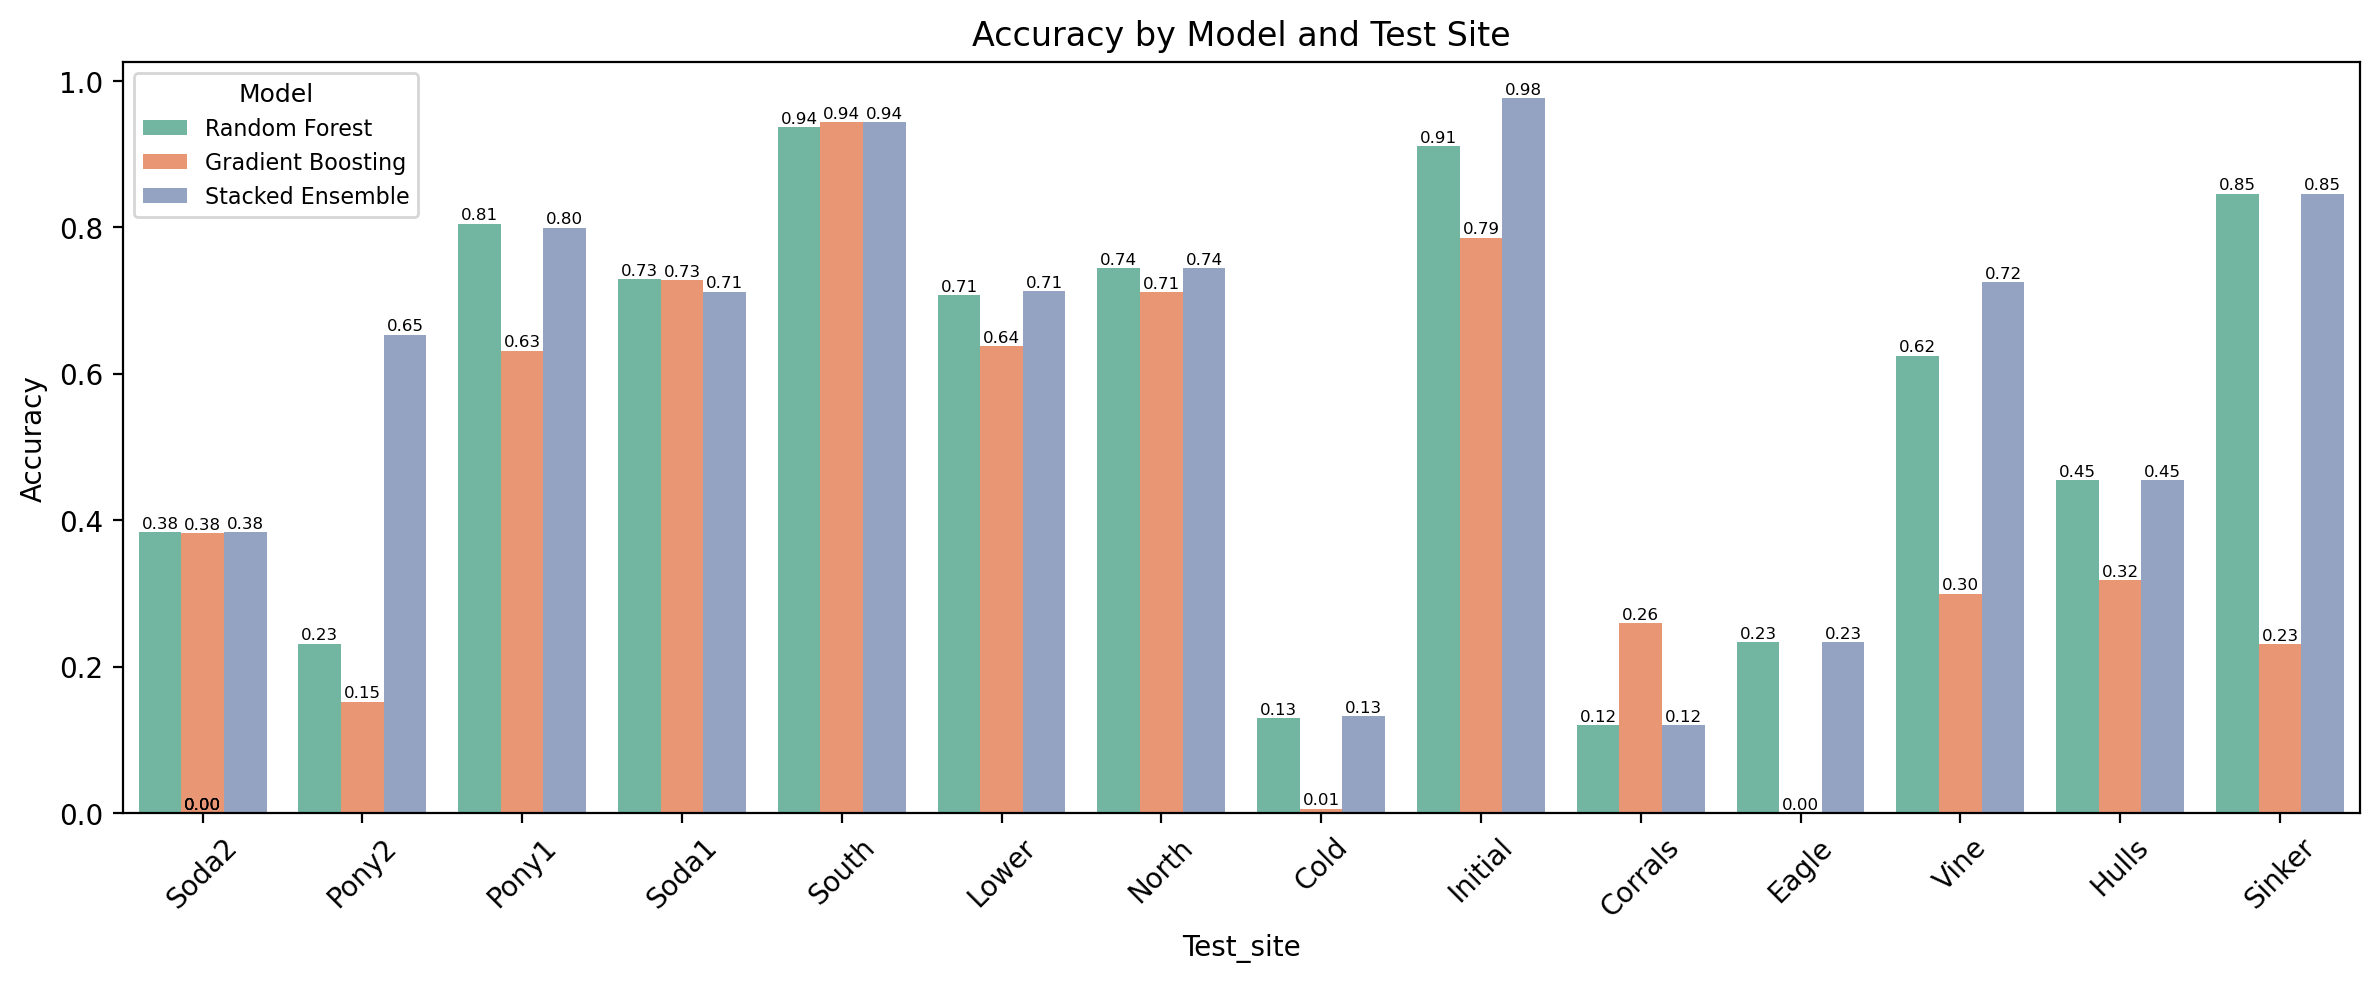

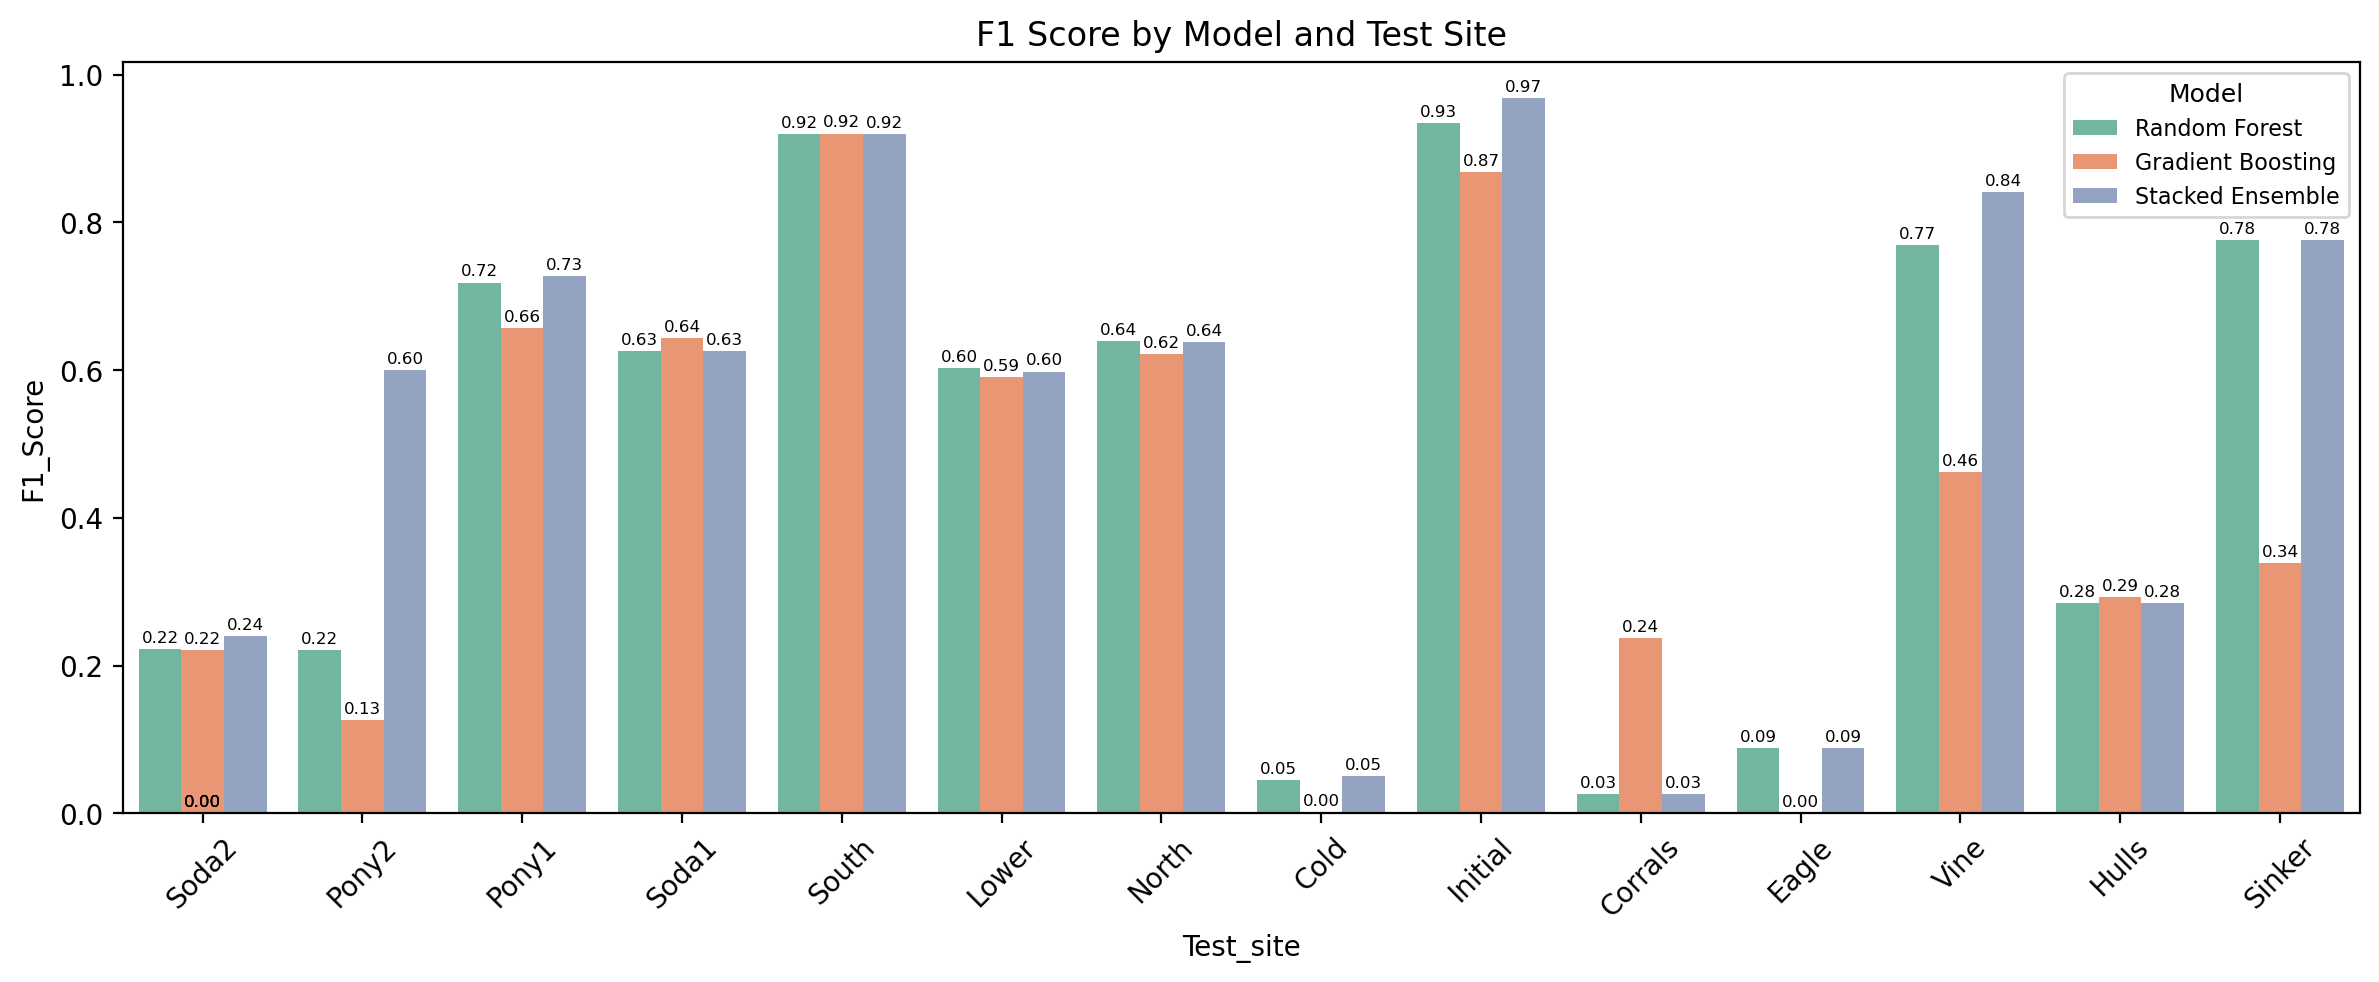

In [14]:
# accuracy plot
plt.figure(figsize=(12, 5))
ax1 = sns.barplot(data=result, x='Test_site', y='Accuracy', hue='Model',  palette='Set2')
plt.title('Accuracy by Model and Test Site')
plt.xticks(rotation=45)


for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',  
                 (p.get_x() + p.get_width() / 2., p.get_height()),  
                 ha='center', va='center',
                 fontsize=6, color='black', xytext=(0, 3), textcoords='offset points')  
plt.legend(title='Model', fontsize=8, title_fontsize=9)  

plt.tight_layout()
plt.show()

# F1 score plot
plt.figure(figsize=(12, 5))
ax2 = sns.barplot(data=result, x='Test_site', y='F1_Score', hue='Model', palette="Set2")
plt.title('F1 Score by Model and Test Site')
plt.xticks(rotation=45)


for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}',  
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 fontsize=6, color='black', xytext=(0,4 ), textcoords='offset points')  

plt.legend(title='Model', fontsize=8, title_fontsize=9)  
plt.tight_layout()
plt.show()


In [33]:
species_counts= ml_df.groupby('site')['Species'].value_counts()
species_counts_df = species_counts.reset_index(name='Count')
print(species_counts_df)


     site  Species  Count
0    Cold     ARAR   1587
1    Cold     ARTR    224
2    Cold  Cirsium     15
3    Cold     PUTR     11
4    Cold     Dead     10
..    ...      ...    ...
66  South     Dead    114
67  South     ACTH      6
68  South     ELEL      4
69  South     ERNA      3
70   Vine     ARTR     40

[71 rows x 3 columns]


/tmp/ipykernel_7137/704504370.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_species)


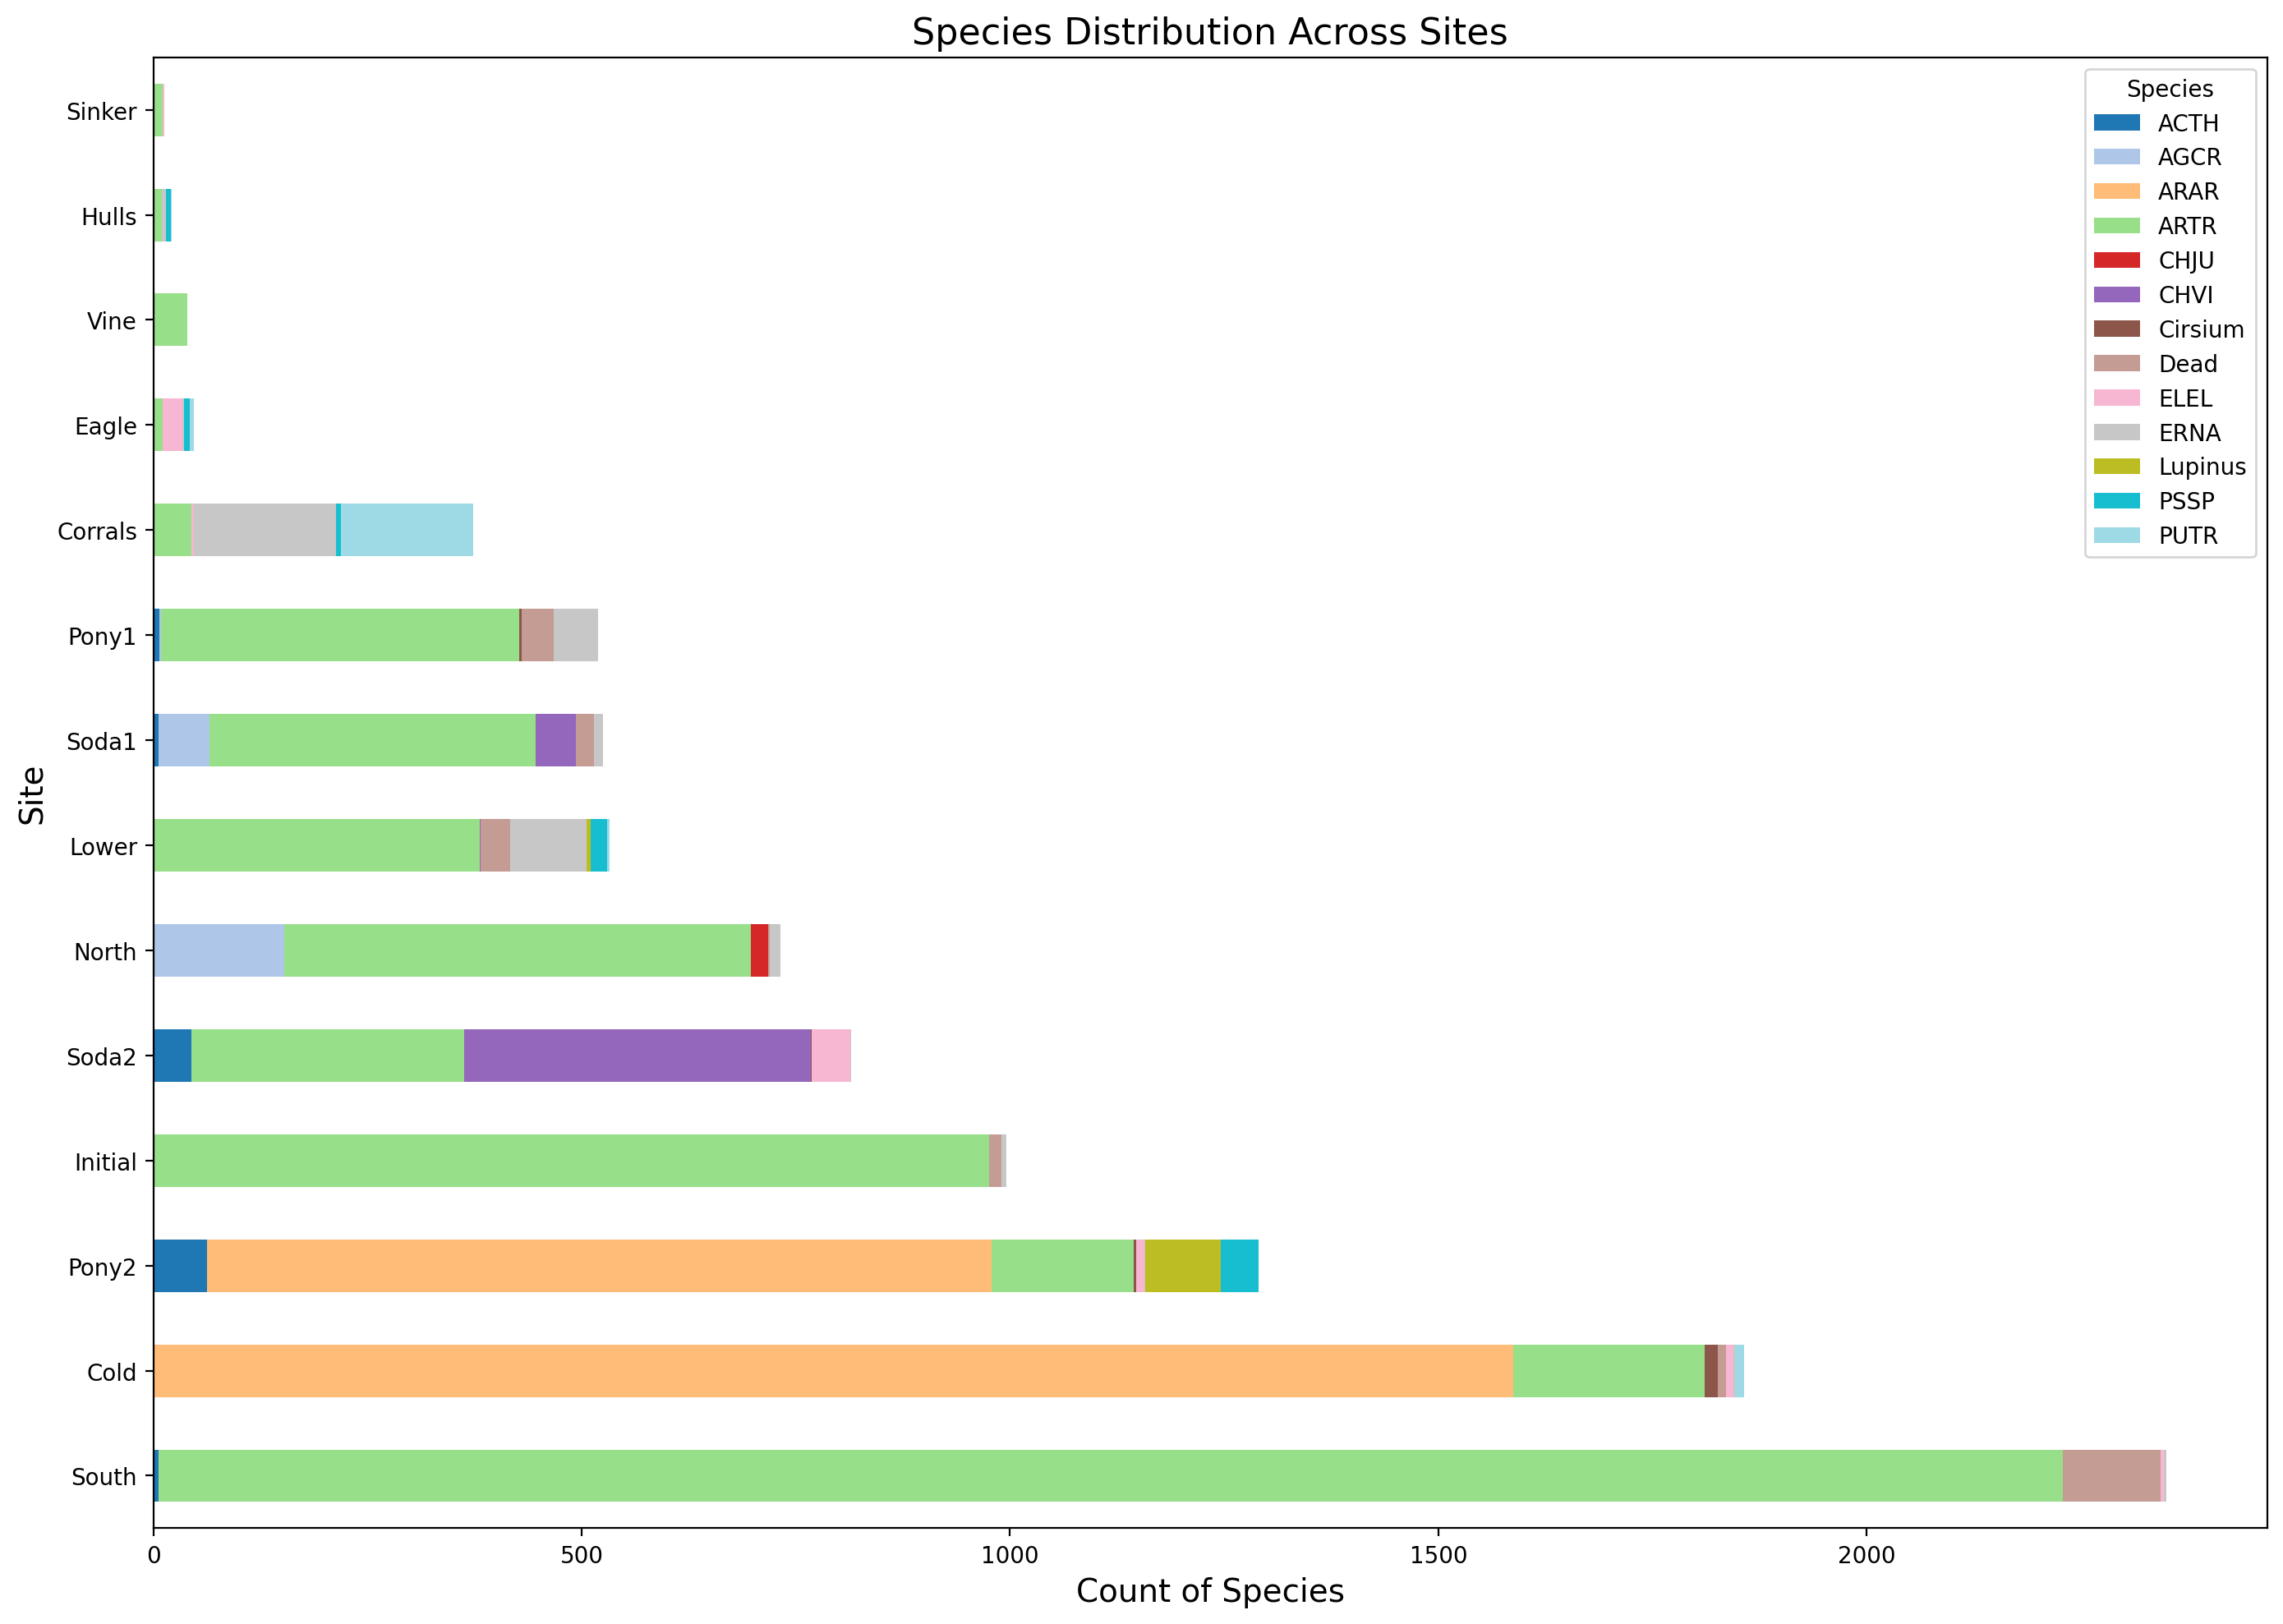

In [43]:

import matplotlib.cm as cm

# Compute total species count per site
site_totals = species_counts.sum(axis=1)

# Sort sites in decreasing order
species_counts_sorted = species_counts.loc[site_totals.sort_values(ascending=False).index]

# Define colormap with unique colors for each species
species = species_counts.columns  
num_species = len(species)
colors = cm.get_cmap('tab20', num_species)  

# Map each species to a unique color
color_mapping = {species[i]: colors(i) for i in range(num_species)}

# Plot sorted bar chart
species_counts_sorted.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 10),
    color=[color_mapping[sp] for sp in species]
)

# Add titles and labels
plt.title('Species Distribution Across Sites', fontsize=16)
plt.xlabel('Count of Species', fontsize=14)
plt.ylabel('Site', fontsize=14)
plt.legend(title='Species')
plt.tight_layout()

# Show plot
plt.show()


<Axes: xlabel='Species'>

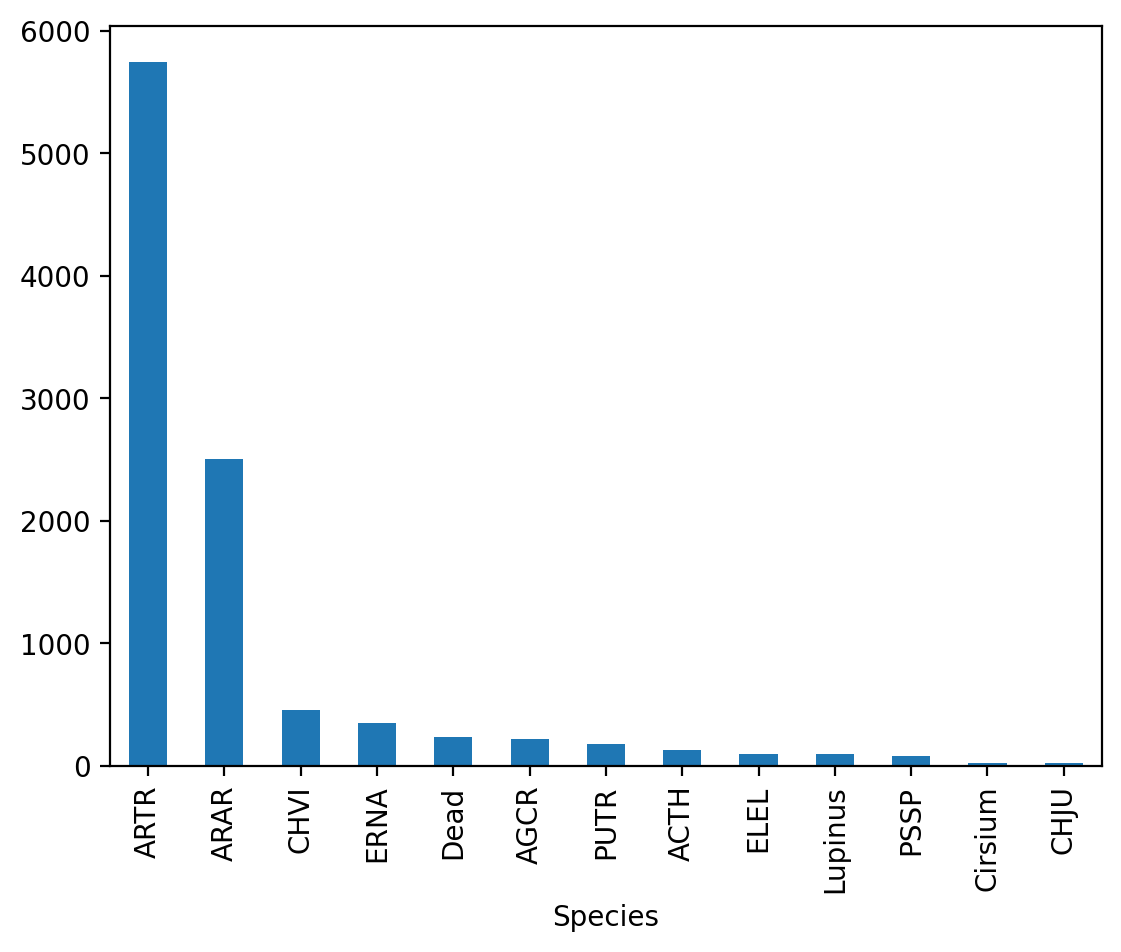

In [44]:
spe_count=ml_df['Species'].value_counts()
spe_count.plot.bar()